<br>
<div class="toc">
    <ul>
        <li><a href="#Preparation">Preparation</a></li>
        <li><a href="#Training">Training</a>
            <ul>
                <li><a href="#Logistic">Logistic Regression</a></li>
                <li><a href="#Random">Random Forest</a></li>
                <li><a href="#XGBClassifier">XGBClassifier</a></li>
                <li><a href="#LGBMClassifier">LGBMClassifier</a></li>
                <li><a href="#DummyClassifier">DummyClassifier</a></li>
            </ul>
        </li>
        <li><a href="#Conclusions">Conclusions</a></li>
    </ul>
</div>

# Detection toxic comments for an online store

The online store launches a new service. Now users can edit and supplement product descriptions, as in wiki communities. That is, clients offer their edits and comment on the changes of others. The store needs a tool that will search for toxic comments and send them for moderation.


The data is in the file `toxic_comments.csv`.

| column | description |
| --- | --- |
| text | comment text |
| toxic | target attribute |

## Preparation

In [1]:
import numpy as np
import pandas as pd
from scipy import stats as st
import time
import warnings
import datetime
import os 
from pathlib import Path
import urllib
import re
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, roc_auc_score, precision_recall_curve, roc_curve
from sklearn.utils import shuffle
from sklearn.dummy import DummyClassifier
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

[nltk_data] Downloading package stopwords to /Users/igor/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/igor/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /Users/igor/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/igor/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/igor/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
data = pd.read_csv('../../../datasets/toxic_comments.csv')

In [3]:
data.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


Let's look at the ratio of classes.

In [5]:
data.groupby('toxic').count()

,text
toxic,
0,143346
1,16225


In [6]:
corpus = data['text'].values

Let's clear the text from unnecessary characters.

In [7]:
def clear_text(text):
    return " ".join(re.sub(r'[^a-zA-Z]', ' ', text).split())

In [8]:
corpus[1]

"D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)"

In [9]:
clear_text(corpus[1])

'D aww He matches this background colour I m seemingly stuck with Thanks talk January UTC'

----

Lemmatizing comments.

In [10]:
lemmatizer = WordNetLemmatizer()

In [11]:
def lemmatize(text):
    word_list = nltk.word_tokenize(text)
    lemmatized = [lemmatizer.lemmatize(word) for word in word_list]
    return " ".join(lemmatized)

In [12]:
corpus[0]

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

In [13]:
lemmatize(clear_text(corpus[0]))

'Explanation Why the edits made under my username Hardcore Metallica Fan were reverted They weren t vandalism just closure on some GAs after I voted at New York Dolls FAC And please don t remove the template from the talk page since I m retired now'

In [14]:
processed_corpus = []

In [15]:
for comment in corpus: 
    processed_corpus.append(lemmatize(clear_text(comment)))

In [16]:
cleared = pd.Series(processed_corpus)

Divide the data into samples in the ratio 75/25

In [17]:
features = cleared
target = data['toxic']
random_state_value = 42

In [18]:
def sampleSize(original, train, test):
    """
    Function for displaying the sizes of resulted samples
    original - original data
    train - training sample
    test - test sample
    """
    print(f'Size of the original data: {len(original)}')
    print(f'Size of the training sample:  {len(train)}')
    print(f'Size of the test sample: {len(test)}')

In [19]:
def cross_val_splitting_data(target,features):
    """
    Function for splitting data into training and test samples. It returns targets, and features of training and test samples
    target
    features
    """
    features_train, features_test, target_train, target_test = train_test_split(features, target,random_state=random_state_value,test_size=0.25)
    # checks sizes of samples
    sampleSize(features,features_train,features_test)
    return features_train,target_train, features_test, target_test

In [20]:
features_train, target_train, features_test, target_test = cross_val_splitting_data(target,features)

Size of the original data: 159571
Size of the training sample:  119678
Size of the test sample: 39893


---

To improve class balances, we will use the `upsampling`

In [21]:
def upsample(features, target,repeat,sample_name):
    features_zeros = features[target==0]
    features_ones = features[target==1]
    target_zeros = target[target==0]
    target_ones = target[target==1]
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=random_state_value)
    print(f'Ration {sample_name}')
    print(target_upsampled.value_counts())
    return features_upsampled, target_upsampled

In [22]:
features_train, target_train = upsample(features_train, target_train, 8, "Training sample")

Ration Training sample
0    107512
1     97328
Name: toxic, dtype: int64


Let's remove frequently repeated words.

In [23]:
stopwords = stopwords.words('english')

In [24]:
count_tf_idf = TfidfVectorizer(stop_words=stopwords)
count_tf_idf.fit(features_train)
features_train = count_tf_idf.transform(features_train)
features_test = count_tf_idf.transform(features_test)

---

## Training

In [25]:
ml_models_stats = dict()

In [26]:
def drawErrorMatrix(error_matrix, model_name):
    plt.title(f'Матрица ошибок модели: {model_name}')
    sns.heatmap(error_matrix, annot=True,cmap='BuPu',cbar=False,fmt="d")
    plt.xlabel('Predictions')
    plt.ylabel('Answers')
    plt.show()

In [27]:
def drawPR_curve(target,features,model):
    probabilities = model.predict_proba(features)
    precision,recall, thresholds = precision_recall_curve(target, probabilities[:,1])
    plt.step(recall, precision, where='post')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Curve Precision-Recall')
    plt.show()

In [28]:
def drawROC_curve(target,features,model):
    probabilities = model.predict_proba(features)
    fpr, tpr, thresholds = roc_curve(target, probabilities[:,1])
    auc_roc = roc_auc_score(target, probabilities[:,1])
    plt.plot(fpr,tpr)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-curve')
    plt.show()
    return auc_roc

In [29]:
def evaluate_model(model_name, model, train_score, features_test, target_test,parameters=None):
    print(f'Evaluation of the model: {model_name}')
    if parameters:
        print(f'with parameters: {parameters}')
    
    print(f'Model accuracy on train sample: {train_score}')
    # Evaluating the accuracy of the model on the test sample
    test_score = model.score(features_test,target_test)
    print(f'Model accuracy on test sample: {test_score}')
    # Generating predictions
    predictions_test = model.predict(features_test)
    # Error matrix
    error_matrix = confusion_matrix(target_test,predictions_test)
    # Recall 
    recall = recall_score(target_test, predictions_test)
    # Precision
    precision = precision_score(target_test, predictions_test)
    # F1 - Score
    f1_Score = f1_score(target_test, predictions_test)
    print()
    # Draw error matrix
    drawErrorMatrix(error_matrix,model_name)
    print()
    # Draw Precision-Recall curve
    drawPR_curve(target_test, features_test, model)
    print()
    # Draw ROC-curve and calculate AUC-ROC area
    auc_roc_score = drawROC_curve(target_test, features_test, model)
    print()
    print(f'Recall - {recall}')
    print(f'Precision - {precision}')
    print(f'F1-Score - {f1_Score}')
    print(f'AUC-ROC_score - {auc_roc_score}')
    # добаляем модель
    ml_models_stats[model_name] = {
        'name': model_name,
        'train_score': train_score,
        'test_score':test_score,
        'recall':recall,
        'precision':precision,
        'f1_score':f1_Score,
        'auc_roc_score':auc_roc_score
    }
    print()
    print('Model has been successfully added!')

<a id='Logistic'></a>
<b>Logistic Regression<b>

In [30]:
%%time
gs_params = {
    'solver': ['liblinear', 'sag','saga','newton-cg'],
    'C': [0.5,1.0,1.5],
    'intercept_scaling':[0.5,1.0,1.5]
}
gs_logistic = RandomizedSearchCV(LogisticRegression(random_state=random_state_value),gs_params,scoring='f1',cv=5, n_iter=20)
gs_logistic.fit(features_train,target_train)

CPU times: user 13min 41s, sys: 12 s, total: 13min 54s
Wall time: 5min 12s


RandomizedSearchCV(cv=5, estimator=LogisticRegression(random_state=42),
                   n_iter=20,
                   param_distributions={'C': [0.5, 1.0, 1.5],
                                        'intercept_scaling': [0.5, 1.0, 1.5],
                                        'solver': ['liblinear', 'sag', 'saga',
                                                   'newton-cg']},
                   scoring='f1')

Evaluation of the model: Logistic Regression
with parameters: {'solver': 'saga', 'intercept_scaling': 1.5, 'C': 1.5}
Model accuracy on train sample: 0.9634236081464621
Model accuracy on test sample: 0.9468327776802948



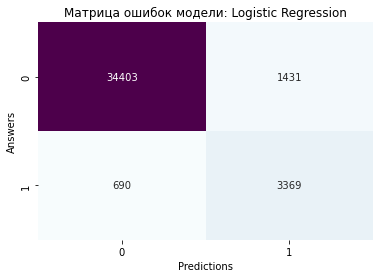

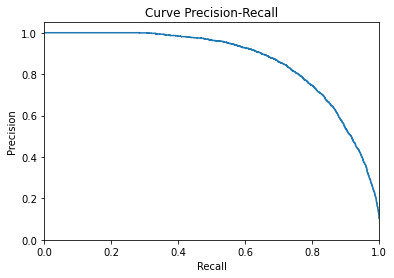

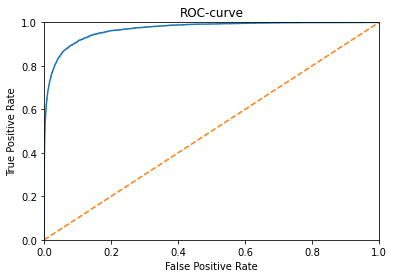


Recall - 0.8300073909830007
Precision - 0.701875
F1-Score - 0.7605824585167626
AUC-ROC_score - 0.9689416699760466

Model has been successfully added!


In [31]:
evaluate_model("Logistic Regression", gs_logistic.best_estimator_, gs_logistic.best_score_,
               features_test, target_test,gs_logistic.best_params_)

---

<a id='Random'></a>
<b>Random Forest</b>

In [32]:
%%time
rs_params = {
    'max_depth': range(1, 26),
    'min_samples_leaf':range(1,11)
}
forest_balanced_rs = RandomizedSearchCV(RandomForestClassifier(random_state=random_state_value),rs_params,scoring='f1',cv=5, n_iter=20)
forest_balanced_rs.fit(features_train, target_train)

CPU times: user 1h 18min 49s, sys: 24.7 s, total: 1h 19min 14s
Wall time: 1h 20min


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=20,
                   param_distributions={'max_depth': range(1, 26),
                                        'min_samples_leaf': range(1, 11)},
                   scoring='f1')

Evaluation of the model: Random Forest
with parameters: {'min_samples_leaf': 3, 'max_depth': 24}
Model accuracy on train sample: 0.8455110815449238
Model accuracy on test sample: 0.8683728975008147



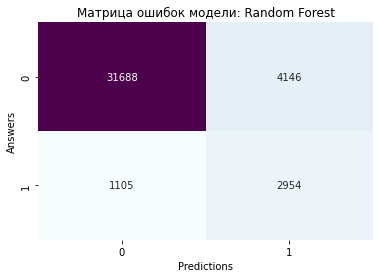

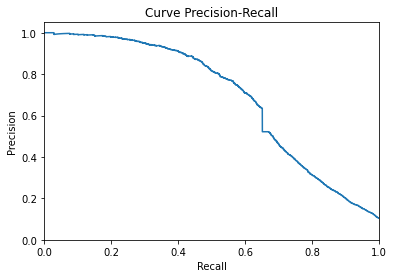

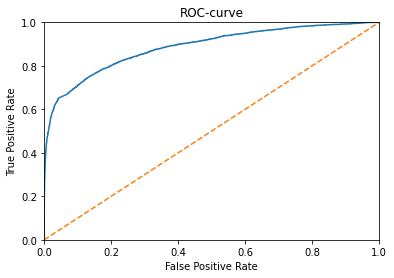


Recall - 0.7277654594727766
Precision - 0.416056338028169
F1-Score - 0.5294381216954924
AUC-ROC_score - 0.8864078370573087

Model has been successfully added!


In [33]:
evaluate_model("Random Forest", forest_balanced_rs.best_estimator_, forest_balanced_rs.best_score_, features_test, target_test,forest_balanced_rs.best_params_)

---

<a id='XGBClassifier'></a>
<b>XGBClassifier</b>

In [34]:
%%time
xgb_params = {
    "max_depth": range(3, 10,2),
    "min_child_weight": range(1,6,2)
}
xgb = xgb.XGBClassifier(nthread=-1) 
xgb_gs = RandomizedSearchCV(xgb, xgb_params, scoring='f1',n_jobs=-1, n_iter=20)
xgb_gs.fit(features_train,target_train)

/Users/igor/opt/anaconda3/envs/analysis/lib/python3.7/site-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 12 is smaller than n_iter=20. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,
/Users/igor/opt/anaconda3/envs/analysis/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:23:38] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CPU times: user 8min 45s, sys: 5.15 s, total: 8min 51s
Wall time: 45min 57s


RandomizedSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           enable_categorical=False, gamma=None,
                                           gpu_id=None, importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                           nthread=-1, num_parallel_tree=None,
                                           predict

Evaluation of the model: XGBoost
with parameters: {'min_child_weight': 1, 'max_depth': 9}
Model accuracy on train sample: 0.9156225547640904
Model accuracy on test sample: 0.9484120021056326



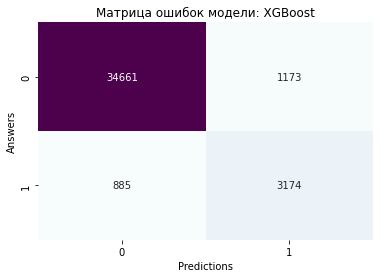

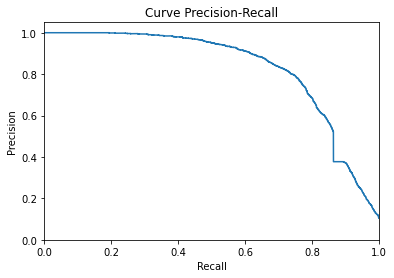

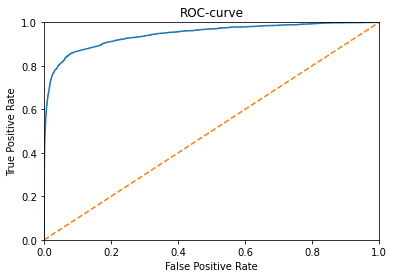


Recall - 0.7819660014781966
Precision - 0.7301587301587301
F1-Score - 0.7551748750892221
AUC-ROC_score - 0.9454470006044542

Model has been successfully added!


In [35]:
evaluate_model("XGBoost", xgb_gs.best_estimator_, xgb_gs.best_score_, features_test, target_test,xgb_gs.best_params_)

---

<a id='LGBMClassifier'></a>
<b>LGBMClassifier</b>

In [36]:
%%time
lgb_params = {
    'objective': ['regression','binary'],
    'boosting_type' : ['dart','gbdt','goss'],
    'max_depth': [15,30],
    'num_leaves': [5,10, 20]
}
lgb_reg = lgb.LGBMClassifier(random_state=random_state_value)
lgb_rs = RandomizedSearchCV(lgb_reg, lgb_params,scoring='f1', cv=5, n_iter=20)
lgb_rs.fit(features_train,target_train)

CPU times: user 6h 27min 31s, sys: 3min 16s, total: 6h 30min 47s
Wall time: 1h 1min 48s


RandomizedSearchCV(cv=5, estimator=LGBMClassifier(random_state=42), n_iter=20,
                   param_distributions={'boosting_type': ['dart', 'gbdt',
                                                          'goss'],
                                        'max_depth': [15, 30],
                                        'num_leaves': [5, 10, 20],
                                        'objective': ['regression', 'binary']},
                   scoring='f1')

Evaluation of the model: LightGBM
with parameters: {'objective': 'binary', 'num_leaves': 20, 'max_depth': 30, 'boosting_type': 'goss'}
Model accuracy on train sample: 0.8684064626102721
Model accuracy on test sample: 0.9434737923946557



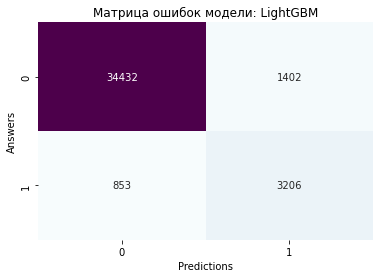

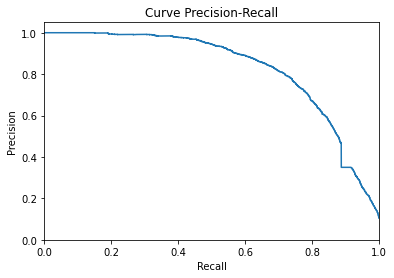

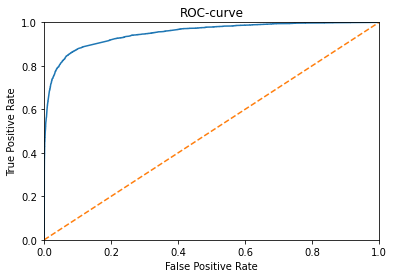


Recall - 0.789849716678985
Precision - 0.6957465277777778
F1-Score - 0.7398176993192569
AUC-ROC_score - 0.9509969618056093

Model has been successfully added!


In [37]:
evaluate_model("LightGBM", lgb_rs.best_estimator_, lgb_rs.best_score_, features_test, target_test,lgb_rs.best_params_)

---

<a id='DummyClassifier'></a>
<b>DummyClassifier</b>

In [38]:
%%time
dummy_model = DummyClassifier(strategy='constant',constant=1, random_state=random_state_value)
dummy_model.fit(features_train,target_train)

CPU times: user 23.1 ms, sys: 4.25 ms, total: 27.3 ms
Wall time: 14 ms


DummyClassifier(constant=1, random_state=42, strategy='constant')

Evaluation of the model: Dummy constant
Model accuracy on train sample: 0.4751415739113454
Model accuracy on test sample: 0.10174717368961973



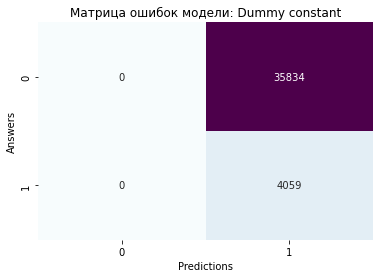

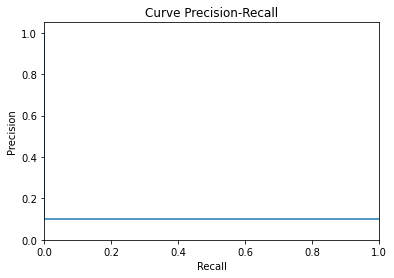

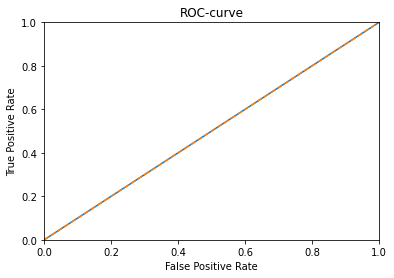


Recall - 1.0
Precision - 0.10174717368961973
F1-Score - 0.1847014925373134
AUC-ROC_score - 0.5

Model has been successfully added!


In [39]:
evaluate_model("Dummy constant", dummy_model, dummy_model.score(features_train,target_train), features_test, target_test)

## Conclusions

As part of the investigation, the following actions were carried out. Text data has been prepared, purification, lemmatization, and deletion of common words have been carried out. Studies have been conducted to identify models with the best `F1-Score`.

In [44]:
pd.DataFrame.from_dict(ml_models_stats, orient="index").style

,name,train_score,test_score,recall,precision,f1_score,auc_roc_score
Logistic Regression,Logistic Regression,0.963424,0.946833,0.830007,0.701875,0.760582,0.968942
Random Forest,Random Forest,0.845511,0.868373,0.727765,0.416056,0.529438,0.886408
XGBoost,XGBoost,0.915623,0.948412,0.781966,0.730159,0.755175,0.945447
LightGBM,LightGBM,0.868406,0.943474,0.789850,0.695747,0.739818,0.950997
Dummy constant,Dummy constant,0.475142,0.101747,1.000000,0.101747,0.184701,0.500000
